# Implicit feedback recommender system - Business case 4

# Table of Contents
- **[1. Business Case](#bc)**
- **[2. Libraries](#lib)**
- **[3. Data Preparation](#datapre)**

# 1. Business Case
<a class="anchor"  id="bc" ></a>

### Business Situation
ManyGiftsUK is a UK-based and registered non-store online retailer with some 80 members of staff. The company was established in 1981 mainly selling unique all-occasion gifts. For years in the past, the merchant relied heavily on direct mailing catalogues, and orders were taken over phone calls. It was only 2 years ago that the company launched its own web site and shifted completely to the web. Since then the company has maintained a steady and healthy number of customers from all parts of the United Kingdom and the world, and has accumulated a huge amount of data about many customers. The company also uses Amazon.co.uk to market and sell its products.

With this new data the company expects to build a recommender system that is able to facilitate user choices by recommending items the user likes and improve user experience when making purchases on its website. A particular challenge is the cold start problem - how can we suggest relevant items to new customers?

The customer transaction dataset held by the merchant has 8 variables as shown below, and it contains all the transactions occurring between 01/12/2010 and 09/12/2011. Over that particular period, there were 25900 valid transactions in total, associated with 4070 unique items and 4372 customers from 38 different countries. The dataset has 541909 instances, each for a particular item contained in a transaction. Also it is important to note that many of ManyGiftsUK customers are wholesalers.

| Name | Meaning|
| :- | :- |
|InvoiceNo|Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.|
|StockCode|Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.|
|Description|Product (item) name. Nominal.|
|Quantity|The quantities of each product (item) per transaction. Numeric.|
|InvoiceDate|Invoice Date and time. Numeric, the day and time when each transaction was generated.|
|UnitPrice|Unit price. Numeric, Product price per unit in pounds.|
|CustomerID|Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.|
|Country|Country name. Nominal, the name of the country where each customer resides.|

### Terminology Alert
- **Recommender Systems:** <br>
A common task of recommender systems is to improve
customer experience through personalized recommendations based on prior implicit feedback. These systems passively track different sorts of user behavior, such as purchase history, watching habits and browsing activity, in order to model user preferences.
- **Implicit vs Explicit:** <br>
Unlike the much more extensively researched explicit feedback, we do not have any
direct input from the users regarding their preferences. In
particular, we lack substantial evidence on which products
consumer dislike.

- **Implicit:** <br>
Thereby treating the
data as indication of positive and negative preference associated with vastly varying confidence levels which leads to a
factor model which is especially tailored for implicit feedback recommenders.

### Important to remember
- All the transactions occurring between 01/12/2010 and 09/12/2011.
- There were *25900 valid transactions* in total, associated with *4070 unique items* and *4372 customers from 38 different countries*.
- The dataset has *541909 instances*, each for a particular item contained in a transaction.
- *Many* of ManyGiftsUK customers are *wholesalers* (not all of them).

### Expected outcome
**1. Explore the data and build models to answer the problems: <br>**
    i. Recommender system: the website homepage offers a wide range of products the user might be interested on. <br>
    ii. Cold start: offer relevant products to new customers. <br>
**2. Implement adequate evaluation strategies and select an appropriate quality measure**<br>
**3. In the deployment phase, elaborate on the challenges and recommendations in implementing the recommender system**

### Optional outcome
- Analyse consumer behvaiour by distinguishing wholesalers with regular customers (clustering)
- Geographic clustering if consumer behaviour differs

# 2. Libraries
<a class="anchor"  id="lib" ></a>

In [1]:
# conventional libraries
import os
import calendar
import pandas as pd
import numpy as np
import os

# data visualizations
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
import seaborn as sns
import matplotlib.pyplot as plt

# algorithm
from scipy.sparse import coo_matrix
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import ranking_metrics_at_k
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 3. Data Preparation   
<a class="anchor" id="datapre"></a>

In [2]:
cwd = os.getcwd()
backOne = os.path.dirname(cwd)

retail = pd.read_csv(str(backOne) + "/Dataset/retail.csv")

In [3]:
print(f"The dataset consists of {retail.shape[0]} rows and {retail.shape[1]} columns")

The dataset consists of 541909 rows and 8 columns


In [4]:
retail['Description'] = retail.Description.str.lower()

### Data type transformation

In [5]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

### Checking for Nans

In [6]:
retail.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
retail[retail['Description'].isna()]['CustomerID'].unique()

array([nan])

In [8]:
df = retail.copy()
df_complete = retail.copy()

In [9]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,NaN,United Kingdom


from the table, most of the description also have 0 unit price, we absolutely want to remove this kind of data. let's check if all null description have 0 unit price.

In [10]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

All the Nan within the *Description* column are within the rows where *CustomerID* is Nan. <br>
Meaning, the dataset contains in total *135080* rows that are Nans.

In [11]:
#remove all the rest from UnitPrice that has 0 value
df_freePrice = df.copy()

df = df[df['UnitPrice']!=0.0]
(df['UnitPrice']==0.0).value_counts()

False    539394
Name: UnitPrice, dtype: int64

can be concluded that all null description have 0 unit, so we have to remove them all

In [12]:
df = df[df['Description'].notnull()]
#df.Description.isna().value_counts()

In [13]:
#remove all the rest from UnitPrice that has 0 value
df_freePrice = df.copy()

df = df[df['UnitPrice']!=0.0]
(df['UnitPrice']==0.0).value_counts()

False    539394
Name: UnitPrice, dtype: int64

### Drop New Customers

First approach: Delete nan values in custoerm

Second approach: Replace nan values with unknow

We are going with the first approach.

In [14]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
print(len(df))

406789


deleted 135080 observations

In [15]:
df.CustomerID = df.CustomerID.astype(int)

### Checking for duplicates

Checking - An example provided below:

In [16]:
df.loc[(df['InvoiceNo'] == '536409') & (df['StockCode'] == '22111')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,scottie dog hot water bottle,1,2010-12-01 11:45:00,4.95,17908,United Kingdom
539,536409,22111,scottie dog hot water bottle,1,2010-12-01 11:45:00,4.95,17908,United Kingdom


Dropping duplicated

In [17]:
print("size before dropping duplicates:", df.shape[0])
df.drop_duplicates(inplace = True)

df.reset_index(drop=True, inplace=True)
print("size after dropping duplicates: ", df.shape[0])

size before dropping duplicates: 406789
size after dropping duplicates:  401564


### Replace StockCode by decoding Description 

We have noticed that different descriptions have been assigned for some stockcodes. Therefore, we have created a new column SC_clean that stores a unique value for each description. This information is needed for the following recommendation system.


In [18]:
df['Description'] = df['Description'].astype("category")
df.insert(loc = 3, column='SC_Clean', value = df['Description'].cat.codes)

### Checking for Cancellations

Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mistery with negative quantities.

Although, we should've gotten deeper into analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

We can actually start a separate project based on that data and predict the returning/cancelling rates for the store.

In [19]:
df[~df['InvoiceNo'].str.contains("C")]

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,white hanging heart t-light holder,3716,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,white metal lantern,3724,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,cream cupid hearts coat hanger,861,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,knitted union flag hot water bottle,1813,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,red woolly hottie white heart.,2776,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...,...
401559,581587,22613,pack of 20 spaceboy napkins,2263,12,2011-12-09 12:50:00,0.85,12680,France
401560,581587,22899,children's apron dolly girl,695,6,2011-12-09 12:50:00,2.10,12680,France
401561,581587,23254,childrens cutlery dolly girl,701,4,2011-12-09 12:50:00,4.15,12680,France
401562,581587,23255,childrens cutlery circus parade,700,4,2011-12-09 12:50:00,4.15,12680,France


In [20]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


Options: <br> 
1. Separate cancelled and not cancelled orders into two separate dfs
2. Decode information by utilizing another binary column (cancelled 1/0) and convert Invoice numbers into integers

**Depends which option maximizes the funcitonallity and accuracy of the algorithm.**

In [21]:
df_cancelled = df[df['InvoiceNo'].str.startswith('C')]
df_cancelled.shape[0]

8872

In [22]:
df[df['InvoiceNo'].str.contains("C")].head()

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,discount,978,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,set of 3 coloured flying ducks,3016,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Checking for counterpart cancelled orders

In [23]:
nb_products_per_basket['cancelled'] = nb_products_per_basket['InvoiceNo'].\
apply(lambda x: 1 if x[0] == "C" else 0)
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products,cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [24]:
nb_products_per_basket[nb_products_per_basket["InvoiceNo"].str.contains("C")]\
['cancelled'].unique()

array([1])

In [25]:
# list of cancelled orders
cancelled_orders_ls = list(nb_products_per_basket.loc\
    [nb_products_per_basket['cancelled'] == 1]['InvoiceNo'].unique())

# removing the 'C' at the beginning of the InvoiceNo
for order in range(len(cancelled_orders_ls)):
    cancelled_orders_ls[order] = cancelled_orders_ls[order][1:]

In [26]:
cancelled_orders_ls[:5]

['541433', '545329', '545330', '547388', '549955']

In [27]:
nb_products_per_basket['Counterpart'] = \
    nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x in cancelled_orders_ls else 0)

In [28]:
nb_products_per_basket['Counterpart'].unique()

array([0])

In [29]:
nb_products_per_basket.loc[nb_products_per_basket['InvoiceNo'] == '544577']

,CustomerID,InvoiceNo,Number of products,cancelled,Counterpart


There's not no counterpart with the exact same InvoiceNo

In [30]:
n1 = nb_products_per_basket['cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
#print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Decoding Stock ID

In [31]:
#combine certain stock types which are obviously simillar differetn colour t-shirts
def f(x):
    if  x[:-1].isdigit() and x[-1].isdigit() is False:
        return x[:-1]
    else : return x
df['StockCode_NR'] = df['StockCode'].apply(f)

In [32]:
#combine certain stock types which are obviously simillar differetn colour t-shirts
def f(x):
    if x[:-1].isdigit() is False:
        return x
    elif x[:-1].isdigit() and x[-1].isdigit():
        return "reg"
    else : return x[-1]
df['StockCode_L'] = df['StockCode'].apply(f)

In [33]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK'],
      dtype=object)

In [34]:
df.StockCode_L.value_counts()

reg             366147
B                 9022
A                 8409
C                 4115
D                 2392
L                 1708
E                 1534
F                 1348
S                 1260
POST              1196
G                 1062
M                  756
P                  623
N                  442
K                  322
15056BL            296
H                  210
U                  165
C2                 134
J                  133
W                  125
R                   68
V                   37
CRUK                16
DOT                 16
BANK CHARGES        12
T                    5
Y                    3
PADS                 3
I                    3
Z                    1
O                    1
Name: StockCode_L, dtype: int64

Getting the TotalPrice for the Invoice

In [35]:
df['QuantityCanceled'] = df['Quantity'].apply(lambda x: (x*-1) if x < 0 else 0)

In [36]:
#df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] + df['QuantityCanceled'])
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] )

data in the timeframe:

In [37]:
print(f"Max date: {df.InvoiceDate.max()} \n\
min date: {df.InvoiceDate.min()}")

Max date: 2011-12-09 12:50:00 
min date: 2010-12-01 08:26:00


Quantity per invoice feature

A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [38]:
df_join = df.groupby('InvoiceNo')[['Quantity']].sum()
df_join = df_join.reset_index()

In [39]:
df = df.merge(df_join, how='left', on='InvoiceNo')
df = df.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df.tail(5)

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,StockCode_L,QuantityCanceled,TotalPrice,QuantityInv
401559,581587,22613,pack of 20 spaceboy napkins,2263,12,2011-12-09 12:50:00,0.85,12680,France,22613,reg,0,10.20,105
401560,581587,22899,children's apron dolly girl,695,6,2011-12-09 12:50:00,2.10,12680,France,22899,reg,0,12.60,105
401561,581587,23254,childrens cutlery dolly girl,701,4,2011-12-09 12:50:00,4.15,12680,France,23254,reg,0,16.60,105
401562,581587,23255,childrens cutlery circus parade,700,4,2011-12-09 12:50:00,4.15,12680,France,23255,reg,0,16.60,105
401563,581587,22138,baking set 9 piece retrospot,271,3,2011-12-09 12:50:00,4.95,12680,France,22138,reg,0,14.85,105


# Feature engineering for EDA only

In [40]:
from math import ceil

df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.strftime("%V")
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 1 if x[0]=='C' else 0)
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.insert(loc=20, column='weekday_nr', value=(df.InvoiceDate.dt.dayofweek)+1)

df_freePrice['Year_Month']=df.InvoiceDate.dt.to_period('M')
df.head()

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Month,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date
0,536365,85123A,white hanging heart t-light holder,3716,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,85123,...,12,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01
1,536365,71053,white metal lantern,3724,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,71053,...,12,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,861,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,84406,...,12,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,1813,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,...,12,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01
4,536365,84029E,red woolly hottie white heart.,2776,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,84029,...,12,48,2010-12,8,3,1,0,Wednesday,Q3,2010-12-01


The min in each column is negative value which probably means a refund order or the data is incorrect but I assume that it's a refund order. I'll check more about it, start with negative Quantity.

In [41]:
df[df['Quantity']<0].head()

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Month,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date
141,C536379,D,discount,978,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,D,...,12,48,2010-12,9,3,1,1,Wednesday,Q3,2010-12-01
154,C536383,35004C,set of 3 coloured flying ducks,3016,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,35004,...,12,48,2010-12,9,3,1,1,Wednesday,Q3,2010-12-01
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01


In [42]:
df[df['CustomerID']==17548].head()

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Month,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
238,C536391,21980,pack of 12 red retrospot tissues,2250,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21980,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01
239,C536391,21484,chick grey hot water bottle,694,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom,21484,...,12,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01


The InvoiceNo has prefix C which probably means canceled order. I'll look into CustomerID 17584 data if we find something else.

The InvoiceNo 550755 and C552049 are exactly the same in quantity and products, but the InvoiceDate of C is over a month later. So I think InvoiceNo with C in prefix is refund order.

Another case is InvoiceNo C536391 which has no matched order but if we look at the InvoiceDate and index, this refund order is very early in dataset, so I think it refund for the order that occured before the company collected the data.

Let's see if there're a lot of refunds.

In [43]:
cnt_order = df[df['Quantity']>0]['InvoiceNo'].nunique()
cnt_refund = df[df['Quantity']<0]['InvoiceNo'].nunique()

print("Total Orders : ",cnt_order)
print("Total Refund Order : ",cnt_refund)
print("%Refund : ",cnt_refund/(cnt_order)*100,"%")

Total Orders :  18532
Total Refund Order :  3654
%Refund :  19.717245845024824 %


Number of refund order is aroud 19%! We should dig deeper to find why the %refund is so high (may be I was wrong about refund).

I create RefundFlg to make in easier when we want to filter it.

In [44]:
df['RefundFlg'] = df['Quantity']<0
df['Description'] = df['Description'].astype(str)

In [45]:
prod_order = df[df['Quantity']>0].groupby(['StockCode_NR','StockCode','Description']).InvoiceNo.nunique().sort_values(ascending = False).reset_index()
prod_order = prod_order.rename(columns = {'InvoiceNo' : 'TotalOrder'})
prod_order_refund = df[df['Quantity']<0].groupby(['StockCode','Description']).InvoiceNo.nunique().sort_values(ascending = False).reset_index()
prod_order_refund = prod_order_refund.rename(columns = {'InvoiceNo' : 'TotalRefundOrder'})

join_prod_order = prod_order.merge(prod_order_refund,left_on = ["StockCode","Description"],right_on = ["StockCode","Description"],how = 'left')
join_prod_order['%Refund'] = join_prod_order['TotalRefundOrder']/join_prod_order['TotalOrder']*100
join_prod_order = join_prod_order.sort_values(by = 'TotalRefundOrder',ascending = False)
join_prod_order.head()

,StockCode_NR,StockCode,Description,TotalOrder,TotalRefundOrder,%Refund
1,22423,22423,regency cakestand 3 tier,1703,180.0,10.569583
408,M,M,manual,253,154.0,60.869565
7,POST,POST,postage,1099,95.0,8.644222
18,22960,22960,jam making set with jars,878,86.0,9.794989
6,22720,22720,set of 3 cake tins pantry design,1146,72.0,6.282723


M doesn't seem like the name of product, may be there is something is hidden inside the data.

This time I'll sort by %refund but select only product that has at least 10 refund order.

In [46]:
join_prod_order = join_prod_order.sort_values(by = '%Refund',ascending = False)
join_prod_order[join_prod_order['TotalRefundOrder']>=10].head(10)

,StockCode_NR,StockCode,Description,TotalOrder,TotalRefundOrder,%Refund
408,M,M,manual,253,154.0,60.869565
2464,23064,23064,cinderella chandelier,22,10.0,45.454545
1753,22198,22198,large popcorn holder,53,15.0,28.301887
1921,23462,23462,rococo wall mirror white,43,12.0,27.906977
1898,22461,22461,savoy art deco clock,45,12.0,26.666667
1681,85159,85159B,"white tea,coffee,sugar jars",59,13.0,22.033898
1597,79191,79191C,retro plastic elephant tray,65,13.0,20.000000
957,21658,21658,glass beurre dish,126,23.0,18.253968
1117,22778,22778,glass cloche small,106,18.0,16.981132
1119,21258,21258,victorian sewing box large,106,18.0,16.981132


If running with all customer, also them with nan values we get the following result:
The top 4 doesn't seem like the name of products and TotalRefundOrder is higher that TotalOrder! From the descriptions, I think in this case, it is about additional fee or discounted fee.

Even the top 4 is not the problems, other products in top 10 seem to be problems and should find out why these product has high %refund.

C2                 133
POST              1099
BANK CHARGES        11
PADS                 3
D 77
M 454
CRUK 16
manual 253

In [47]:
prod_only_order = join_prod_order[~join_prod_order['StockCode_NR'].isin(['AMAZONFEE','BANK CHARGES', 'C2', 'POST',
                                                                     'CRUK', 'PADS', 'M', 'D', 'S'])]
TotalRefundProdOrder = prod_only_order['TotalRefundOrder'].sum()
TotalReProdOrder = prod_only_order['TotalOrder'].sum()

print("%Refund : ",TotalRefundProdOrder/TotalReProdOrder*100,"%")

%Refund :  2.1887230033338168 %


In [48]:
df1 = df[(df['StockCode_NR'] == 'AMAZONFEE') | (df['StockCode_NR'] == 'C2') | (df['StockCode_NR'] == 'BANK CHARGES')
         | (df['StockCode_NR'] == 'POST') | (df['StockCode_NR'] == 'CRUK') | (df['StockCode_NR'] == 'PADS')
         | (df['StockCode_NR'] == 'M') | (df['StockCode_NR'] == 'D') | (df['StockCode_NR'] == 'S')]
print("We are deleting rows which are no products", df1.shape[0])

#we delete 693 rows
df = df.drop(df[(df['StockCode_NR'] == 'AMAZONFEE') | (df['StockCode_NR'] == 'C2') | (df['StockCode_NR'] == 'BANK CHARGES')
                | (df['StockCode_NR'] == 'POST') | (df['StockCode_NR'] == 'CRUK') | (df['StockCode_NR'] == 'PADS')
                | (df['StockCode_NR'] == 'M') | (df['StockCode_NR'] == 'D') | (df['StockCode_NR'] == 'S')].index)

We are deleting rows which are no products 1892


In [49]:
#combine certain stock types which are obviously simillar differetn colour t-shirts
def f(x):
    if x[:-1].isdigit() is False:
        return x
    elif x[:-1].isdigit() and x[-1].isdigit():
        return "reg"
    else : return x[-1]
df['StockCode_L'] = df['StockCode'].apply(f)

### Data Transformation

In [50]:
df[(df['Quantity']<=0) | (df['UnitPrice']<0)].count()

InvoiceNo           8506
StockCode           8506
Description         8506
SC_Clean            8506
Quantity            8506
InvoiceDate         8506
UnitPrice           8506
CustomerID          8506
Country             8506
StockCode_NR        8506
StockCode_L         8506
QuantityCanceled    8506
TotalPrice          8506
QuantityInv         8506
Sales               8506
Year                8506
Month               8506
Week                8506
Year_Month          8506
Hour                8506
weekday_nr          8506
Day                 8506
is_cancelled        8506
weekday             8506
Quarter             8506
Date                8506
RefundFlg           8506
dtype: int64

In [51]:
print("Percentage of negative quantity or unitprice:", (9253/df.shape[0])*100)

Percentage of negative quantity or unitprice: 2.3151484217057985


9290 rows have Quantity in negative or UnitPrice negative. This might mean they are return orders, or we are not sure of the reason why they are so. 9k out of 401,601 records, we may trim it out and be fine with the data we will have left. Let's proceed that way.

Generally, unit price is at least 0, thus any unit price is below the baseline is considered as outliers.

"Negative quantities" appear to be damaged/lost/unknown items. Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [52]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date,RefundFlg
154,C536383,35004C,set of 3 coloured flying ducks,3016,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,35004,...,48,2010-12,9,3,1,1,Wednesday,Q3,2010-12-01,True
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
238,C536391,21980,pack of 12 red retrospot tissues,2250,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21980,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True


In [53]:
df.shape[0]

399672

In [54]:
df[df['InvoiceNo'].str.contains("C")]

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date,RefundFlg
154,C536383,35004C,set of 3 coloured flying ducks,3016,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,35004,...,48,2010-12,9,3,1,1,Wednesday,Q3,2010-12-01,True
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
238,C536391,21980,pack of 12 red retrospot tissues,2250,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21980,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401118,C581490,22178,victorian glass hanging t-light,3550,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom,22178,...,49,2011-12,9,5,9,1,Friday,Q3,2011-12-09,True
401119,C581490,23144,zinc t-light holder stars small,3891,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,23144,...,49,2011-12,9,5,9,1,Friday,Q3,2011-12-09,True
401370,C581568,21258,victorian sewing box large,3551,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,21258,...,49,2011-12,11,5,9,1,Friday,Q3,2011-12-09,True
401371,C581569,84978,hanging heart jar t-light holder,1576,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,84978,...,49,2011-12,11,5,9,1,Friday,Q3,2011-12-09,True


In [55]:
#Lets delete negative unitprice from the data and proceed with further analysis
df_negPQ = df.copy()
df_negPQ.to_csv('df_negqual.csv' ,index= False)

##df = df[~df['InvoiceNo'].str.startswith('C')]

In [56]:
df[df['InvoiceNo'].str.contains("C")]

,InvoiceNo,StockCode,Description,SC_Clean,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockCode_NR,...,Week,Year_Month,Hour,weekday_nr,Day,is_cancelled,weekday,Quarter,Date,RefundFlg
154,C536383,35004C,set of 3 coloured flying ducks,3016,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,35004,...,48,2010-12,9,3,1,1,Wednesday,Q3,2010-12-01,True
235,C536391,22556,plasters in tin circus parade,2581,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,22556,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
236,C536391,21984,pack of 12 pink paisley tissues,2247,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21984,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
237,C536391,21983,pack of 12 blue paisley tissues,2238,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21983,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
238,C536391,21980,pack of 12 red retrospot tissues,2250,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,21980,...,48,2010-12,10,3,1,1,Wednesday,Q3,2010-12-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401118,C581490,22178,victorian glass hanging t-light,3550,-12,2011-12-09 09:57:00,1.95,14397,United Kingdom,22178,...,49,2011-12,9,5,9,1,Friday,Q3,2011-12-09,True
401119,C581490,23144,zinc t-light holder stars small,3891,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom,23144,...,49,2011-12,9,5,9,1,Friday,Q3,2011-12-09,True
401370,C581568,21258,victorian sewing box large,3551,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom,21258,...,49,2011-12,11,5,9,1,Friday,Q3,2011-12-09,True
401371,C581569,84978,hanging heart jar t-light holder,1576,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom,84978,...,49,2011-12,11,5,9,1,Friday,Q3,2011-12-09,True


# Outlier detection

Quantity
Most invoices cluster around 0, in a range of [-10000, 10000].
There are some outliers way above and below the range above. We can safely remove for the sake of revenue analysis.

/opt/anaconda3/envs/DMDSAA/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



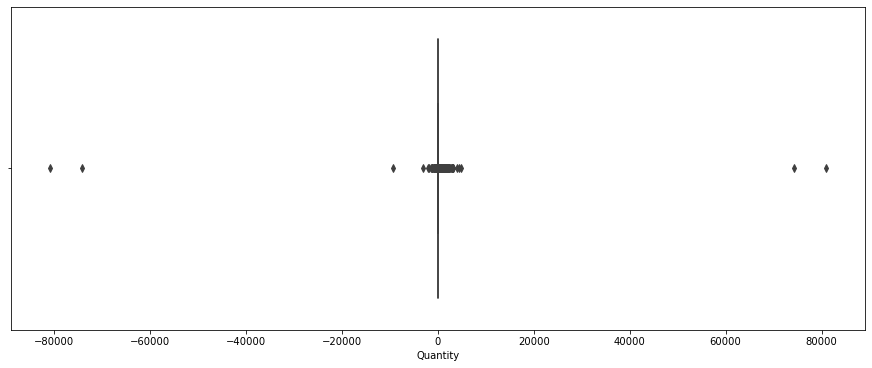

In [57]:
# Plot Quantity
plt.figure(constrained_layout=True, figsize=(12, 5))
sns.boxplot(df['Quantity'])

# remove outliers for Quantity
df = df[(df['Quantity'] < 20000) & (df['Quantity'] > -20000)]

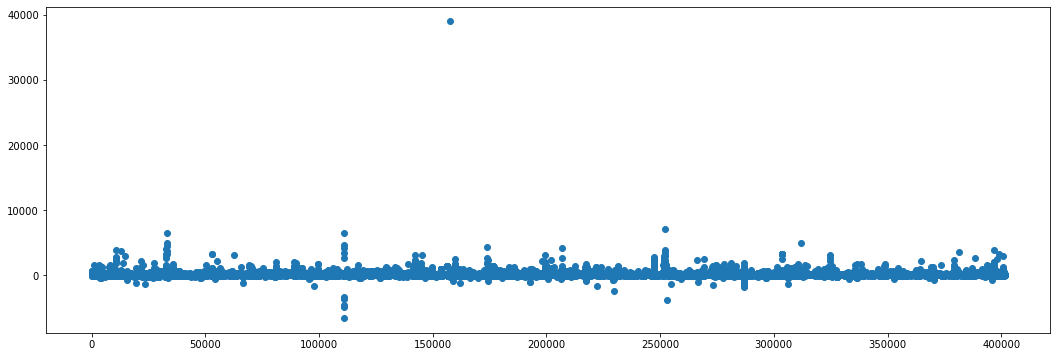

In [58]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['TotalPrice'])

(array([-50000.,      0.,  50000., 100000., 150000., 200000., 250000.,
        300000., 350000., 400000., 450000.]),
 <a list of 11 Text major ticklabel objects>)

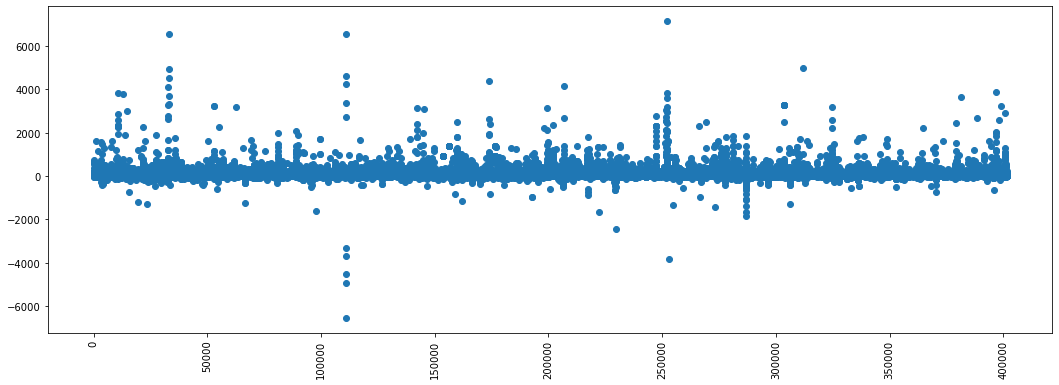

In [59]:
df = df[(df['TotalPrice'] < 10000) & (df['TotalPrice'] > -10000)]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['TotalPrice'])
plt.xticks(rotation=90)

In [60]:
print("initial size:", retail.shape[0])
print("size after data preprocessing:", df.shape[0])
print("difference:", retail.shape[0] - df.shape[0])

initial size: 541909
size after data preprocessing: 399667
difference: 142242


In [61]:
df_withC = df.copy()

In [62]:
df = df[df['UnitPrice'] >= 0] # only 2 observations
df = df[df['Quantity'] > 0] # 9288

In [63]:
df_withC.to_csv(str(backOne) + "/Application/dataset/df_withC.csv" ,index= False)
df_withC.to_csv("df_withC.csv" ,index= False)
df.to_csv('df_cleaned.csv' ,index= False)